# Paper Results
July 29, 2025

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils.Barcode import Barcode
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss
from NDNT.utils import subplot_setup
from NDNT.utils import figure_export

# Clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix
from sklearn.linear_model import LogisticRegression

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
start    = time.time()
data     = SimCloudData(down_sample=3, num_lags=11)
end      = time.time()

print('CPU Time', end-start, 'sec')

CPU Time 62.604655742645264 sec


In [3]:
start     = time.time()
test_data = SimCloudData(filename='cloud_TEST_data_stim_dim120_spike_time_sqrad_0.3.hdf5', down_sample=3, num_lags=11, test=True)
end       = time.time()

print('CPU Time', end-start, 'sec')

CPU Time 18.72498059272766 sec


In [4]:
test_robs = test_data.repeat_robs
test_dfs = test_data.repeat_dfs
print(test_robs.shape)
print(test_dfs.shape)

(30000, 10, 1491)
(30000, 10, 1491)


In [5]:
# Load baseline LL
GLM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.npy')
GQM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.npy')

# Load baseline LL
GLM_R2 = np.load('data/cloud_test_data_stim_dim_120_sqrad_0.3_GLM_R2.npy')
GQM_R2 = np.load('data/cloud_test_data_stim_dim_120_sqrad_0.3_GQM_R2.npy')

In [6]:
# Load Complexity Index (calculated from GQM)
comp = np.load('data/2-28_update_all_neuron_complexity_sqrad_0.3.npy')

In [7]:
cell_idx_dict = data.cell_idx_dict
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))

L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']

In [8]:
num_lags = data.num_lags
L  = data.stim_dims[1]
NC = data.NC
NT = data.NT
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

num_lags = 11
L = 40
Number of cells 1491
Number of time points 480000


In [9]:
# cell key
cell_key = data.cell_key

# integer cell key
int_key = np.zeros(NC)
int_key[L4_exc_idx] = 1
int_key[L4_inh_idx] = 2
int_key[L23_exc_idx] = 3
int_key[L23_inh_idx] = 4

# cell key dict
key_dict = {}
key_dict['L4 Exc'] = 1
key_dict['L4 Inh'] = 2
key_dict['L2/3 Exc'] = 3
key_dict['L2/3 Inh'] = 4

colors = ['tab:blue', 'tab:cyan', 'tab:red', 'm']

## Load Full Model

In [10]:
full_model = NDN.load_model('models/0728_Full_Model_30ang.ndn')
full_model.eval()
full_model.block_sample = True
full_model.loss_module.unit_weighting = True
full_model.networks[1].layers[0].Qsample_mode = 'nearest'
full_model.networks[1].layers[0].sample = False

## Full Model Performance

In [11]:
test_pred = full_model.predictions(test_data, data_inds=np.arange(test_data.NB), batch_size=1, num_lags=num_lags, device=device).detach().cpu().numpy()
full_R2 = comp_test_R2(test_robs, test_dfs, test_pred)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.48it/s]


In [13]:
print('R2 mean', np.mean(full_R2), '+/-', np.std(full_R2))
print('L4 Exc Mean R2:', np.mean(full_R2[L4_exc_idx]), '+/-', np.std(full_R2[L4_exc_idx]))
print('L4 Inh Mean R2:', np.mean(full_R2[L4_inh_idx]), '+/-', np.std(full_R2[L4_inh_idx]))
print('L2/3 Exc Mean R2:', np.mean(full_R2[L23_exc_idx]), '+/-', np.std(full_R2[L23_exc_idx]))
print('L2/3 Inh Mean R2:', np.mean(full_R2[L23_inh_idx]), '+/-', np.std(full_R2[L23_inh_idx]))

R2 mean 0.4358877830876845 +/- 0.12317142437295407
L4 Exc Mean R2: 0.4470501156920654 +/- 0.12911431260991343
L4 Inh Mean R2: 0.6018499668809066 +/- 0.07067965554497643
L2/3 Exc Mean R2: 0.3821269842075178 +/- 0.0844167770659007
L2/3 Inh Mean R2: 0.38003323457347155 +/- 0.05424271516667731


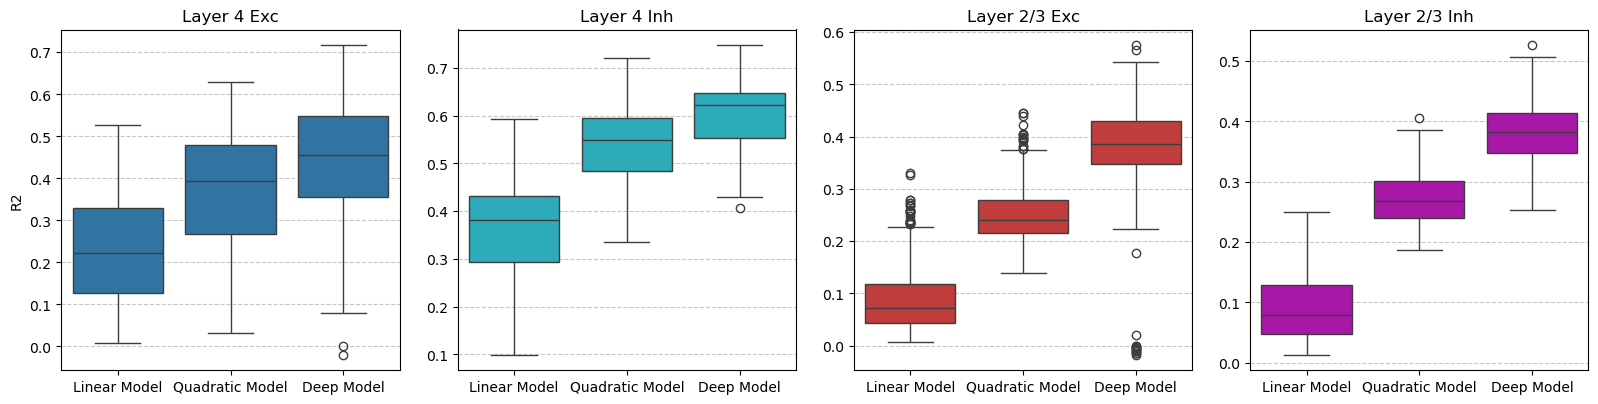

In [14]:
ss(1,4)
plt.subplot(1,4,1)
R2_to_plot = [GLM_R2[L4_exc_idx], GQM_R2[L4_exc_idx], full_R2[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=R2_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('R2')
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
R2_to_plot = [GLM_R2[L4_inh_idx], GQM_R2[L4_inh_idx], full_R2[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=R2_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
R2_to_plot = [GLM_R2[L23_exc_idx], GQM_R2[L23_exc_idx], full_R2[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=R2_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
R2_to_plot = [GLM_R2[L23_inh_idx], GQM_R2[L23_inh_idx], full_R2[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=R2_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')
plt.show()

## Full Model Filters

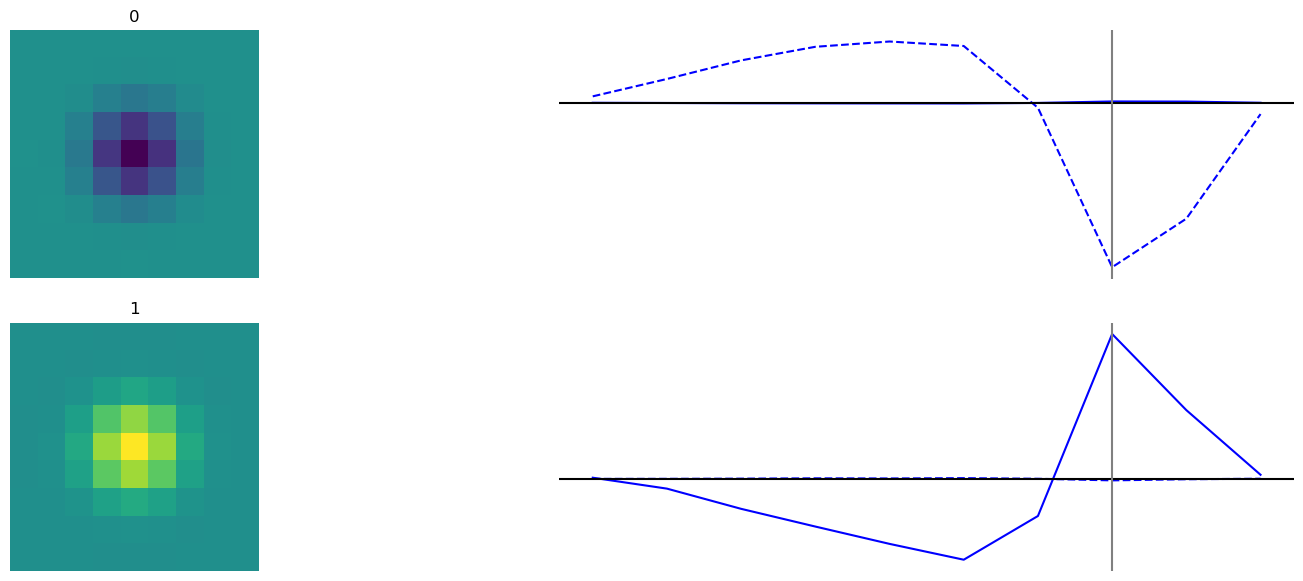

In [15]:
full_model.plot_filters()

In [16]:
filters1 = full_model.get_weights(ffnet_target=0,layer_target=1)
ei_mask_layer1 = deepcopy(full_model.networks[0].layers[1]._ei_mask).detach().cpu().numpy()
print(filters1.shape)

(2, 19, 19, 16)


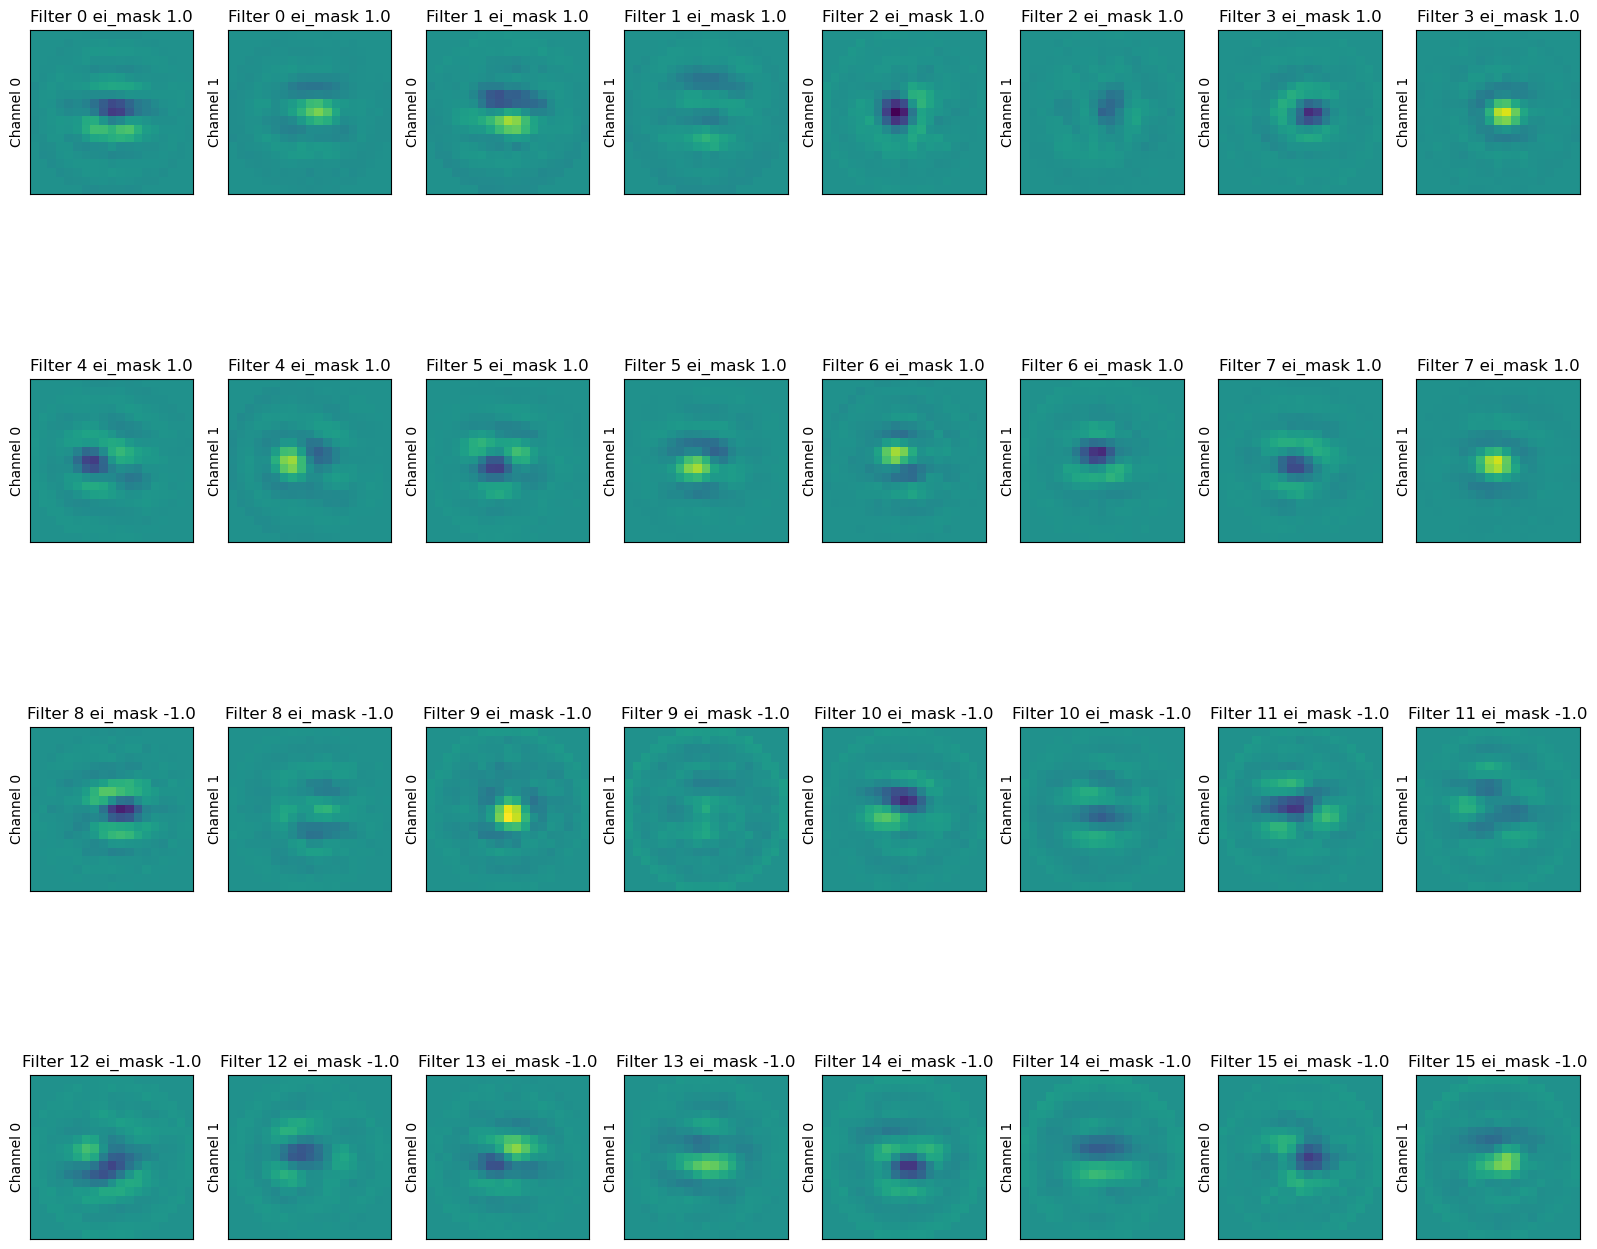

In [17]:
ss(4,8)
k = 1
cmin = np.min(filters1)
cmax = np.max(filters1)
for i in range(16):
    plt.subplot(4,8,k)
    imagesc(filters1[0,:,:,i], balanced=True)
    plt.title('Filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.ylabel('Channel 0')
    plt.clim(cmin,cmax)
    plt.xticks([])
    plt.yticks([])
    k += 1

    plt.subplot(4,8,k)
    imagesc(filters1[1,:,:,i], balanced=True)
    plt.title('Filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.ylabel('Channel 1')
    plt.clim(cmin,cmax)
    plt.xticks([])
    plt.yticks([])
    k += 1

plt.tight_layout()
plt.show()

## Full Model Barcodes

In [18]:
layer_list = [1,3,4]
full_BC = Barcode(full_model, data, layer_list=layer_list)
barcode_idx = []
aux = 0
for i in range(len(layer_list)):
    layer = deepcopy(full_model.networks[0].layers[layer_list[i]])
    exc, inh = layer.num_filters-layer.num_inh, layer.num_inh
    aux += exc
    barcode_idx.append(aux)
    aux += inh
    barcode_idx.append(aux)
print(barcode_idx)

[8, 16, 22, 28, 34, 40]


### Filter-Based BC

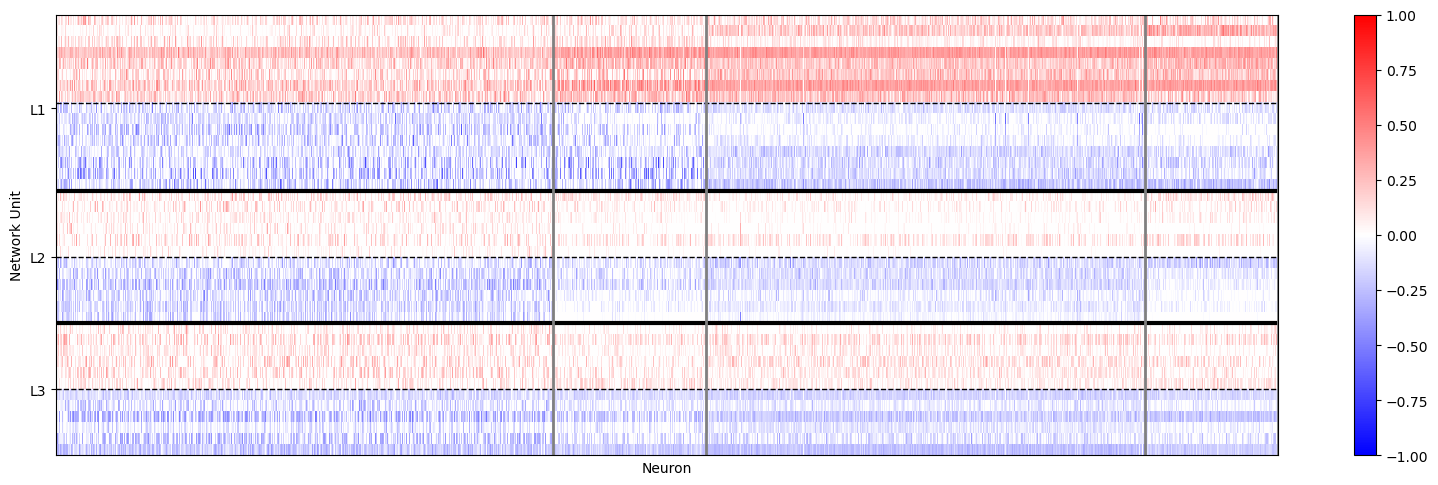

In [19]:
f = ss(rh=5, fighandle=True)
full_BC.plot_barcode(labels=int_key)
plt.ylabel('Network Unit')
plt.xlabel('Neuron')
plt.xticks([])
plt.show()
#figure_export(f, 'full_model_BC.pdf')

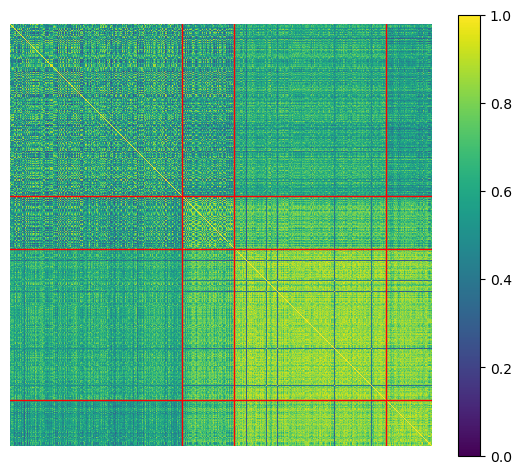

In [21]:
f = subplot_setup(1, 1, row_height=5, fig_width=6, fighandle=True)
full_BC.cosine_similarity(plot=True, cmin=0)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
plt.axis('off')
plt.show()
figure_export(f, 'full_model_cos_sim_mat.pdf')

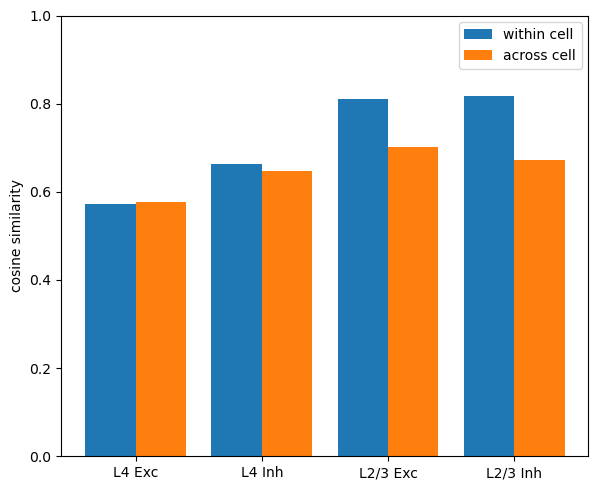

In [22]:
f = subplot_setup(1, 1, row_height=5, fig_width=6, fighandle=True)
full_BC.sim_vs_diff_bar_plot(labels=int_key, labels_key=key_dict)
figure_export(f, 'full_model_cos_sim_bar.pdf')